# Analysis Example with Dask

## Analysis Overview

- Define cruise altitude
- Join engine turbine speed data with cruise altitude data
- Investigate potential correlations between turbine speed and cruise altitude

## Imports/Setup

In [1]:
import metaflow
import opal.flow
from math import sqrt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from opal.weave.create_index import create_index_from_s3

In [2]:
# TEST_ENV is set in the test_all script
# found in opal/devops-software.
# test_flag is set to boolean true when this notebook is being tested
test_flag = False
if "TEST_ENV" in os.environ:
    test_flag = True

## Gather References to Uploaded Data

In [3]:
s3 = opal.flow.minio_s3fs()
# translate_flow = metaflow.Flow("TipTranslateFlow")
# midnight_run = list(metaflow.Flow('TipMidnightCatalog').runs('production'))[0]
# tip_catalog_df = pd.read_parquet(midnight_run.data.data_files['parquet_table'], filesystem = s3)
# tip_catalog_df.head()

index = create_index_from_s3('old-ch10s', 'schema.json')
index_1553 = index[index['basket_type'] == 'ch10_translated_MILSTD1553'].copy()
index_arinc = index[index['basket_type'] == 'ch10_translated_ARINC429'].copy()
translated_index = index_arinc.rename(columns = {'address':'arinc_path'})
translated_index['milstd1553_path'] = [index_1553.address[index_1553.label == label].iloc[0] for label in translated_index.label]

##  Define Cruise Altitude
Note: reference comments for details on how cruise altitude is defined

Using chapter 10 652200101100441


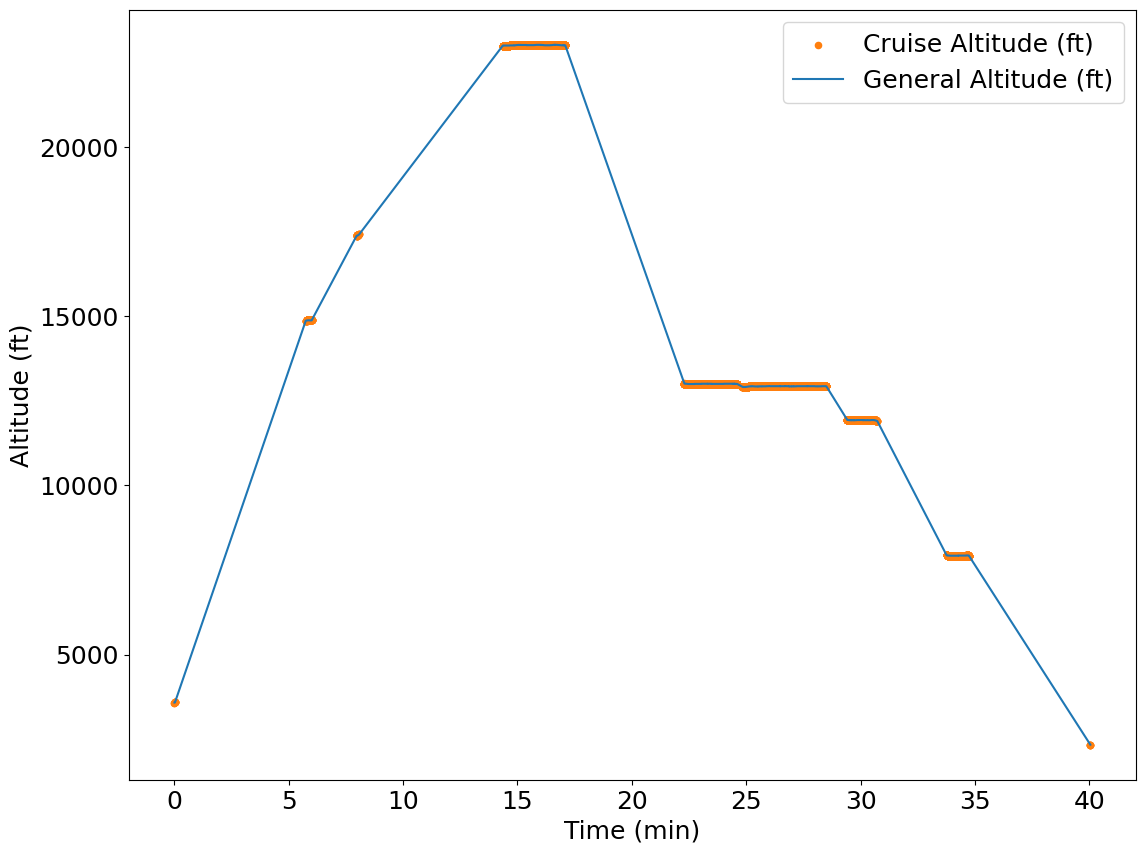

In [4]:
plt.rcParams.update({"font.size":18})
altitude = "NAV-25"
altitude_valid = "NAV-0111"
rpm = "N1_RPM_ACTUAL"
rpm_dataset = "Engine_Fan_RPM_N1_ACTUAL_40"

def plot_cruise_altitude(t_1553):
    # Get the 1553 data
    df_1553 = pd.read_parquet(t_1553, filesystem=s3)
    
    # Filter 1553 by the 'altitude valid'
    df_1553 = df_1553[df_1553[altitude_valid]]
    df_1553 = df_1553.dropna()
    
    # Calculate change in altitude over time (time is in nanoseconds)
    df_1553.loc[:,"diff_altitude"] = df_1553[altitude].diff() / (df_1553["time"].diff() / 10**9)
    # Smooth out the altitude derivative
    df_1553.loc[:,"diff_altitude"] = df_1553["diff_altitude"].rolling(int(1 / 0.04)).mean()
    
    # Select only where altitude rate of change is small enough (< 0.25 ft/sec.)
    # and the aircraft is sufficiently above what we think is ground level
    start_altitude = df_1553[altitude].iloc[:10].mean()
    end_altitude = df_1553[altitude].iloc[-10:].mean()
    min_altitude = max(start_altitude, end_altitude)
    df_1553 = df_1553[abs(df_1553["diff_altitude"]) < 0.25]
    df_1553 = df_1553[df_1553[altitude] > min_altitude * 2]
    df_1553 = df_1553.dropna()
    min_time = df_1553['time'].min()
    df_1553['flight_time_min'] = (df_1553['time'] - min_time) / 10**9 / 60
    
    ax = df_1553.plot(kind="scatter", x="flight_time_min", y=altitude, c="tab:orange", label="Cruise Altitude (ft)", figsize=(13,10))
    df_1553.plot(x="flight_time_min", y=altitude, ax=ax, label="General Altitude (ft)")
    ax.set_ylabel("Altitude (ft)")
    ax.set_xlabel("Time (min)")

# first_row = tip_catalog_df.iloc[0]
basket = translated_index.iloc[0]
print(f"Using chapter 10 {basket['label']}")
nav_path = os.path.join(basket['milstd1553_path'],'parsed_data_translated', 'NAV.parquet', '00.parquet')
plot_cruise_altitude(nav_path)

## Join engine turbine speed data with cruise altitude data

### Function for Joining turbine speed data with cruise altitude data

In [5]:
def get_rpm_at_cruise_altitude(t_1553, t_429):
    # get the 1553 and ARINC429 data
    df_1553 = pd.read_parquet(t_1553, filesystem=s3)
    df_429 = pd.read_parquet(t_429, filesystem=s3)
    
    # filter 1553 by the 'altitude valid' bit
    df_1553 = df_1553[df_1553[altitude_valid]]
    
    # join 1553 and ARINC429 data by time
    joined = pd.concat([ df_1553[["time", altitude]], df_429[["time", rpm]] ]).sort_values("time")
    joined[rpm] = joined[rpm].fillna(method="ffill")
    joined = joined.dropna().copy()
    
    # calculate change in altitude over time (time is in nanoseconds)
    joined.loc[:,"diff_altitude"] = joined[altitude].diff() / (joined["time"].diff() / 10**9)
    # smooth out the altitude derivative
    joined.loc[:,"diff_altitude"] = joined["diff_altitude"].rolling(int(1 / 0.04)).mean()
    
    # select only where difference in altitude is small enough
    # and the aircraft is sufficiently above what we think is ground level
    start_altitude = joined[altitude].iloc[:10].mean()
    end_altitude = joined[altitude].iloc[-10:].mean()
    min_altitude = max(start_altitude, end_altitude)
    joined = joined[abs(joined["diff_altitude"]) < 0.25]
    joined = joined[joined[altitude] > min_altitude * 2]
    joined = joined.dropna()
    
    # group periods of time when the jet was cruising, take the average
    joined['group'] = (joined['time'].diff() > 60 * 10**9).cumsum()
    grouped = joined.groupby('group').mean()
    return grouped[[altitude, rpm]]

### Run the function __get_rpm_at_cruise_altitude()__ with Dask

In [6]:
%%time
from dask.distributed import Client, progress
import dask.bag
import dask.dataframe
import os

with Client(n_workers=16, processes=True) as client:  
    dashboard_port = client.cluster.dashboard_link.split(':')[-1].split('/')[0]
    dashboard_link = f"https://opal.opalacceptance.dso.mil{os.environ['JUPYTERHUB_SERVICE_PREFIX']}proxy/{dashboard_port}/status"
    print(dashboard_link)
    if test_flag:
        end_index = 10
    else:
        end_index = -1
    # ds_bag = dask.bag.from_sequence(tip_catalog_df.iloc[0:end_index].iloc)
    ds_bag = dask.bag.from_sequence(translated_index.iloc[0:end_index].iloc)
    # ds_bag = ds_bag.filter(lambda row: not pd.isnull(row["NAV"]) and not pd.isnull(row[rpm_dataset]))
    
    analysis_count = ds_bag.count().compute()
    #ds_bag = ds_bag.map(lambda row: get_rpm_at_cruise_altitude(row["NAV"], row[rpm_dataset]))
    ds_bag = ds_bag.map(lambda row: get_rpm_at_cruise_altitude(os.path.join(row['milstd1553_path'],'parsed_data_translated', 'NAV.parquet', '00.parquet'),
                                                               os.path.join(row['arinc_path'],'parsed_data_translated', f'{rpm_dataset}.parquet', '00.parquet'))
                       )
    future = client.compute(ds_bag)
    progress(future, notebook=False)
    df = pd.concat(future.result())

https://opal.opalacceptance.dso.mil/user/nathan.christiansen.1/proxy/8787/status
CPU times: user 1.97 s, sys: 440 ms, total: 2.41 sCompleted |  1.5s
Wall time: 6.15 s


In [7]:
print(f' Datasets Analyzed = {analysis_count}')

 Datasets Analyzed = 9


### Plot Results

<Axes: title={'center': 'Turbine Speed at Cruise Altitude (all flights)'}, xlabel='Cruise Altitude (ft)', ylabel='Engine Turbine Speed (Percent Max.)'>

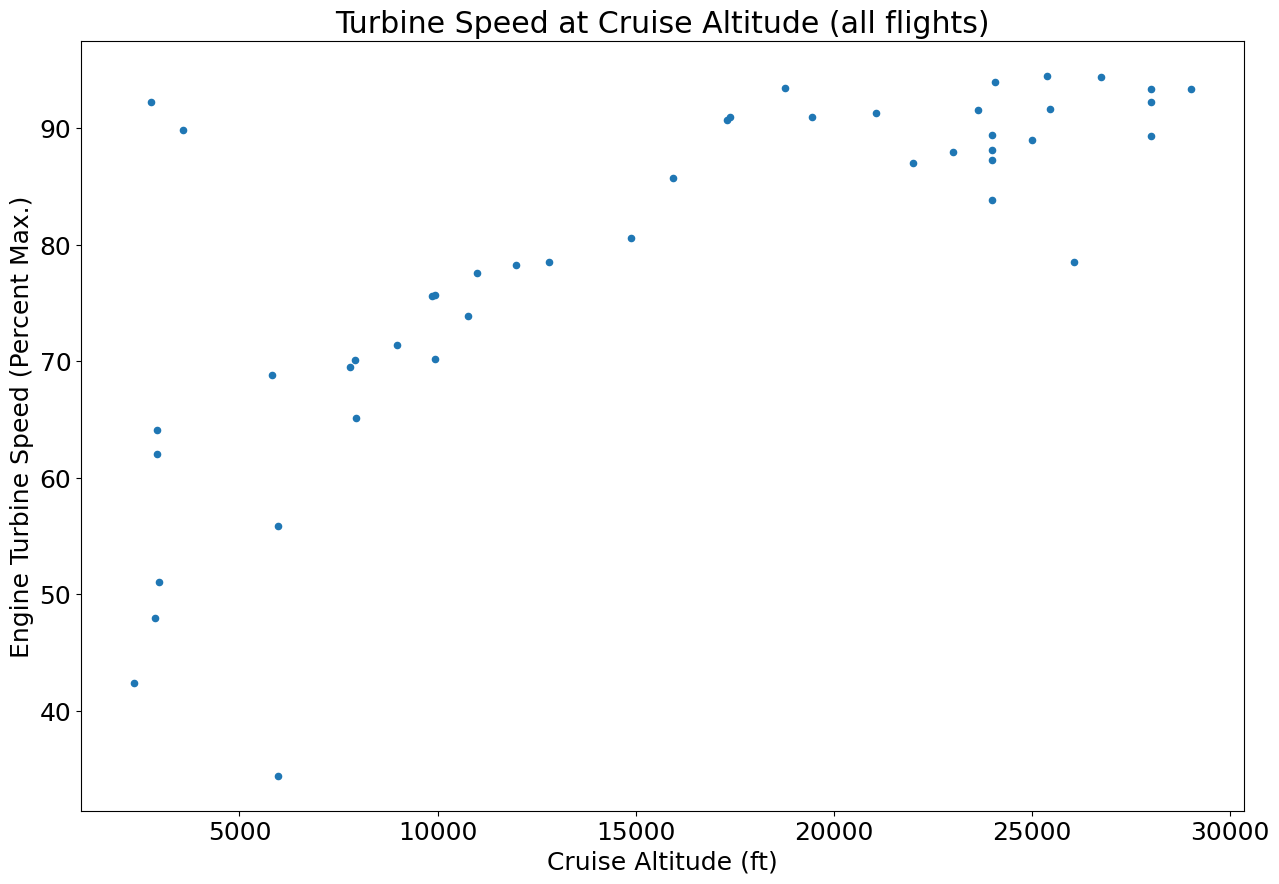

In [8]:
df.plot(
    kind="scatter", x=altitude, y=rpm, 
    xlabel="Cruise Altitude (ft)", ylabel="Engine Turbine Speed (Percent Max.)",
    title="Turbine Speed at Cruise Altitude (all flights)",
    figsize=(15, 10)
)

## Investigate potential correlations between turbine speed and cruise altitude

### Fit the Data to a Linear Regression Model

In [9]:
X = np.array(df['NAV-25']).reshape(-1,1)
y = df['N1_RPM_ACTUAL']
reg = LinearRegression().fit(X, y)

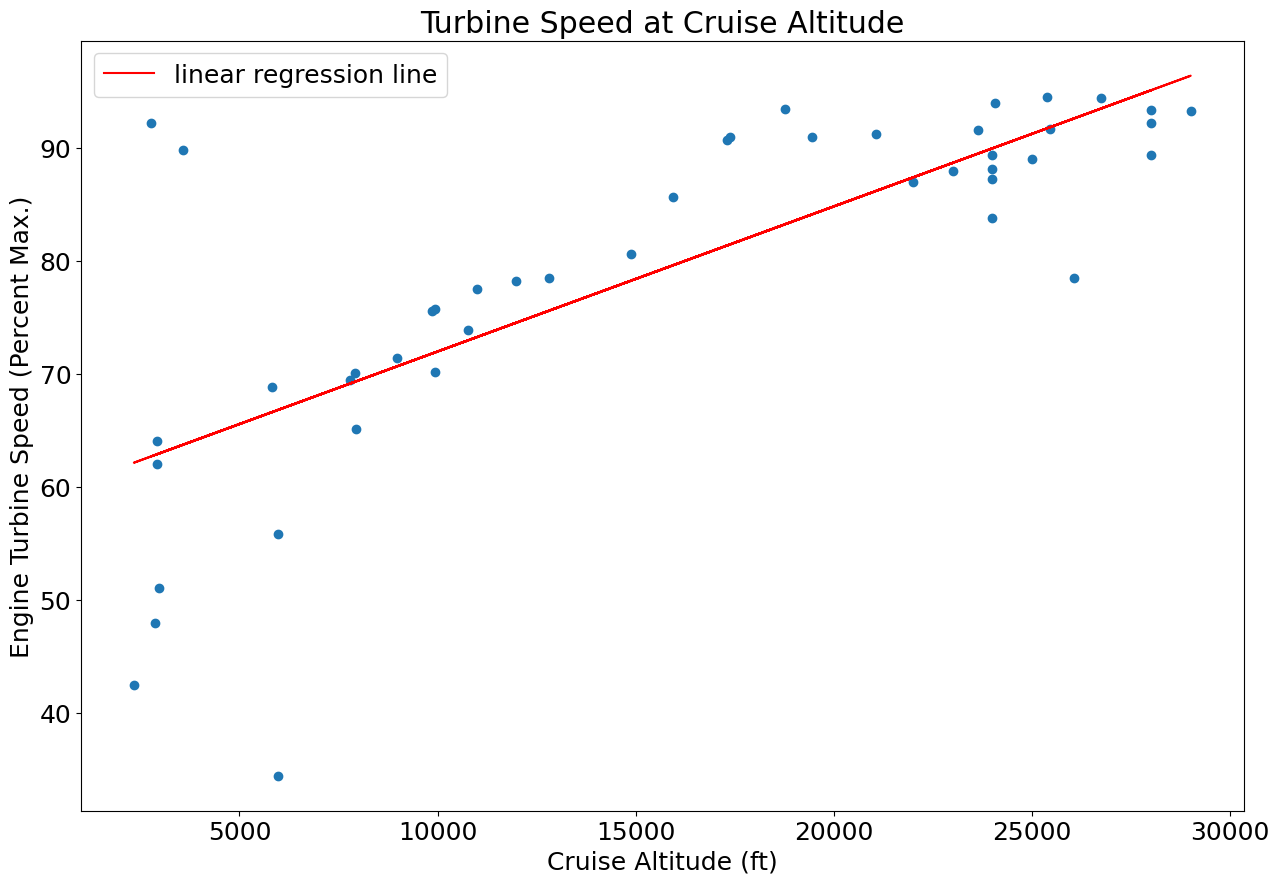

In [10]:
fig = plt.figure(figsize=(15, 10))
plt.title("Turbine Speed at Cruise Altitude")
plt.scatter(X, y)
plt.plot(X, reg.predict(X),color='r', label='linear regression line')

plt.xlabel("Cruise Altitude (ft)")
plt.ylabel ("Engine Turbine Speed (Percent Max.)")
plt.legend()
plt.show()

### Score the Model

In [11]:
reg.score(X, y)

0.5747419322741174

### Calculate Correlation Coefficients

In [12]:
cors_with_target = df.drop(['N1_RPM_ACTUAL'], axis=1).corrwith(df['N1_RPM_ACTUAL'])
cors_with_target

NAV-25    0.758117
dtype: float64

# Conclusion

- Engine Turbine Speed is "Highly Correlated" with Cruise Altitude (0.79 pearson correlation) 
- A Linear Model isn't a great model to predict Engine Turbine RPM given Cruise Altitude (62% accuracy)
- 559 flights were analyzed within ~ 1 minute using 16 workers with Dask